# **<span style="color: black;">STAT 201 Project Proposal - Group 38</span>** 
##### **-- by Pushya Jain, Jingyuan Liu, Ty Stevenson & Bowen Tian**

## **Statistical inference on crime statistics of Vancouver**

### **Introduction**

<span style="color: black;">In our STAT201 group project, we propose the following question of interest: **How does the proportion of violent  crimes vary through the day in recent years?** With the rise of unprovoked stranger attacks and safety concerns for Vancouverites, we will seek to better understand the relation of criminal activity and time of day. The data is provided by the Vancouver Police Department on the open source “geodash” website. We will be using the data from 2003 to 2022 for all neighborhoods within the Vancouver municipal proper. The goal of this study is to understand if daytime and nighttime hours tend to harbour different types of crimes, which may be useful in further inferences about the motivations behind such crimes (*CS Wisdom et H. Torch*). These trends can also assist in predicting criminal activity and developing preventive and punitive methods to reduce crime, and understand the underlying social problems conducive to crimes (*University of Minnesota*).</span>

In [10]:
### Load all necessary packages into Jupyter and set the seed. Run this cell before continuing.
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(repr)
library(cowplot)
library(broom)
library(digest)
library(infer)
library(gridExtra)
set.seed(38)
options(repr.matrix.max.rows = 8)

### **Preliminary results**

<span style="color: black;">In our preliminary and exploratory analysis, we downloaded the dataset as .csv and read it into Jupyter. We immediately noticed that there are spikes in the distribution around midnight. We assumed this to be an artifact of estimating crime time in instances where the precise time is unknown. To counteract this problem, we used a histogram to bin the dataset by the hour and removed values at midnight. This may cause the unintended effect of removing useful data. However, as we are comparing the two groups by daytime and nighttime, it should have little effect on the proportions calculated. We also use the more recent data from 2002 onwards. The histograms in question are shown below:</span>

Rows: 842492 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Theft from Vehicle,2017,2,21,22,0,1XX W GEORGIA ST,Central Business District,491892.3,5458408
Theft from Vehicle,2017,3,8,12,45,1XX W GEORGIA ST,Central Business District,491892.3,5458408
Theft from Vehicle,2017,3,14,20,0,1XX W GEORGIA ST,Central Business District,491892.3,5458408
Theft from Vehicle,2017,5,8,9,47,1XX W GEORGIA ST,Central Business District,491892.3,5458408
Theft from Vehicle,2017,5,17,13,18,1XX W GEORGIA ST,Central Business District,491892.3,5458408
Theft from Vehicle,2017,6,16,17,30,1XX W GEORGIA ST,Central Business District,491892.3,5458408


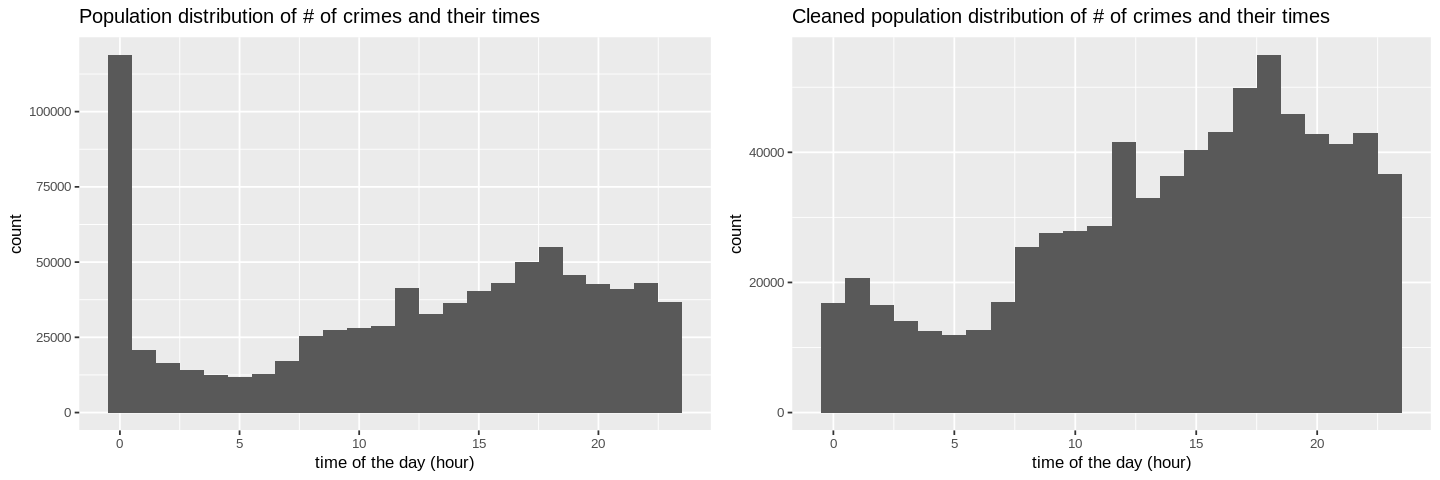

In [11]:
#Read the raw data from the web using its url.
url <- "https://raw.githubusercontent.com/PUSH-YA/stat-201-2022w1-group-38/main/crimedata_csv_AllNeighbourhoods_AllYears.csv"
vancouver_crime_raw_data <- read_csv(url)
head(vancouver_crime_raw_data)

#Initial population distribution
pop_plot <- vancouver_crime_raw_data %>% 
            ggplot() +
            geom_histogram(aes(x = HOUR), bins =24) +
            theme(text = element_text(size = 10)) +
            labs(x = "time of the day (hour)", 
                title = "Population distribution of # of crimes and their times",
                y = "count")

#Cleaning the data
vancouver_clean_data <- vancouver_crime_raw_data %>%
                            filter(!(HOUR == 0 & MINUTE == 0) & YEAR > 2002) %>%
                            select(TYPE, HOUR, MINUTE)

pop_plot_clean <- vancouver_clean_data %>% 
            ggplot() +
            geom_histogram(aes(x = HOUR), bins =24) +
            theme(text = element_text(size = 10)) +
            labs(x = "time of the day (hour)", 
                title = "Cleaned population distribution of # of crimes and their times",
                y = "count")

options(repr.plot.width=12, repr.plot.height=4)
grid.arrange(pop_plot, pop_plot_clean, ncol =2)

We checked the type of data in the dataset. We classified it accordingly where mischied and theft were counted as non-violent crimes and the rest would eb counted as violent crimes. After dividing the types of crime, we changed the data accordingly to highlight the categorisation. 

The new data with categorised labels will be then further divided into night (6pm to 6am) and day time (6am to 6pm). These 2 groups' proportion of violent crimes was calculated and used to calculate a difference in proportion. This gave us a difference of $\approx$**0.23%**.

The code for these is shown below:

In [12]:
#Checking the types of crims
crime_types <- vancouver_crime_raw_data %>%
                group_by(TYPE) %>%
                summarise(count = n()) %>%
                pivot_wider(
                    names_from = TYPE,
                    values_from = count
                )

crime_types

Break and Enter Commercial,Break and Enter Residential/Other,Homicide,Mischief,Offence Against a Person,Other Theft,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury)
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
45904,71244,301,100901,72890,206918,235580,36090,44151,337,28176


day_violent_prop,night_violent_prop,diff_in_prop
<dbl>,<dbl>,<dbl>
0.1926652,0.190354,0.002311217


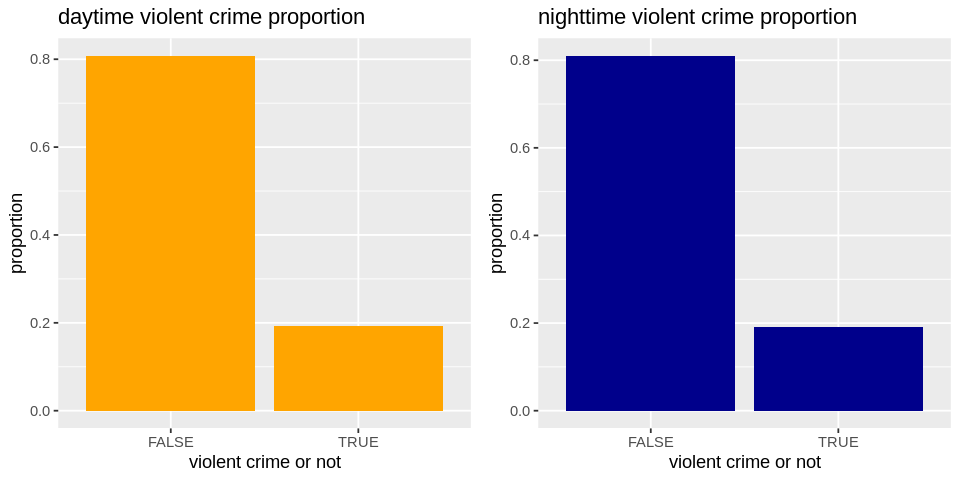

In [13]:
#dividing the types of crime data
vancouver_clean_data <- vancouver_clean_data %>% mutate(violent = TYPE %in% c("Break and Enter Commercial", "Break and Enter Residential/Other", "Homicide", 
                                                                           "Offence Against a Person", "Vehicle Collision or Pedestrian Struck (with Fatality)",
                                                                           "Vehicle Collision or Pedestrian Struck (with Injury)"))


#dividing it into daytime and nighttime data
daytime_data <- vancouver_clean_data %>% filter(HOUR >= 6 & HOUR < 18)
nighttime_data <- vancouver_clean_data %>% filter(HOUR < 6 | HOUR >= 18)

#data visualisation
daytime_plot <- daytime_data %>% group_by(violent) %>% summarise(n = n()/nrow(daytime_data)) %>%
                ggplot(aes(x = violent, y = n)) + geom_bar(fill = "orange", stat = "identity") +
                labs(x = "violent crime or not", y = "proportion", title = "daytime violent crime proportion")


nighttime_plot <- nighttime_data %>% group_by(violent) %>% summarise(n = n()/nrow(nighttime_data)) %>%
                ggplot(aes(x = violent, y = n)) + geom_bar(fill = "darkblue", stat = "identity") +
                labs(x = "violent crime or not", y = "proportion", title = "nighttime violent crime proportion")

#creating a summary table
daytime_prop <- daytime_data %>% summarise(prop = mean(violent))
nighttime_prop <- nighttime_data %>% summarise(prop = mean(violent))
summary_table <- tibble( day_violent_prop = daytime_prop$prop[1],
                       night_violent_prop = nighttime_prop$prop[1],
                       diff_in_prop = daytime_prop$prop[1] - nighttime_prop$prop[1])
summary_table

options(repr.plot.width=8, repr.plot.height=4)
grid.arrange(daytime_plot, nighttime_plot, ncol =2)

### **Methods: plan**

 
The plots and the preliminary calculation above is still not enough to reject null hypothesis as there are sampling and statistical errors that need to be addressed. We are going to use theory based approaches to find a confidence interval for the difference and for our hypothesis testing and compare it against the bootstrapping approach to answer our question. These methods should account for both types of error and  the bootstrapping comparison will account for the assumptions in the first approach.  We expect to find differences between rates of crime severity.

$H_0: p_1 - p_0 = 0$  

$H_A: p_1 - p_0 \neq 0$

We still suspect violent crimes occur disproportionately during nighttime, especially types such as vehicular fatality under alcohol influence. If our hypothesis is confirmed, it can be extremely useful for public safety, and help law enforcement agencies distribute resources adequately and perform more efficiently.
    
    
Additional inquiry could be relevant to address police presence on the frequency of crime, in deterring more violent varieties that occur during the night, as well as performing a more thorough analysis on crimes such as burglary.



### **References**


- VPD OPEN DATA. (n.d.). “Vancouver Police Department Crime Data.”, Retrieved from https://geodash.vpd.ca/opendata/ and https://opendata.vancouver.ca/pages/home/
-  Chester Ismay and Albert Y. Kim (2022e, October 28). Statistical Inference via Data Science. https://moderndive.com/
- CS Widom; H Toch. “Contribution of Psychology to Criminal Justice Education.” CONTRIBUTION OF PSYCHOLOGY TO CRIMINAL JUSTICE EDUCATION | Office of Justice Programs, Retrieved from https://www.ojp.gov/ncjrs/virtual-library/abstracts/contribution-psychology-criminal-justice-education
- University of Minnesota. “8.2 Types of Crime.” Social Problems, University of Minnesota Libraries Publishing Edition, 2015. This Edition Adapted from a Work Originally Produced in 2010 by a Publisher Who Has Requested That It Not Receive Attribution., 25 Mar. 2016, Retrieved from https://open.lib.umn.edu/socialproblems/chapter/8-2-types-of-crime/ 